In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

In [2]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, activation='relu'):
        super().__init__()
        layers = []

        if activation == 'relu':
            activation_function = nn.ReLU
        elif activation == 'tanh':
            activation_function = nn.Tanh
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_function())
        
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_function())
        
        # Output layer
        layers.append(nn.Linear(hidden_dim, 1))  # output size is 1
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [3]:
model = FFNN(input_dim=10, hidden_dim=64, n_layers=2, activation='tanh')
x = torch.randn(5, 10)  # batch of 5 samples
output = model(x)
print(output.shape)  # should print torch.Size([5, 1])
print(output)

torch.Size([5, 1])
tensor([[ 0.3690],
        [-0.0241],
        [-0.0098],
        [ 0.1151],
        [ 0.0504]], grad_fn=<AddmmBackward0>)


In [4]:
model.model

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): Tanh()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [5]:
def train_to_convergence(model,
                         x_train,
                         y_train,
                         optimizer,
                         criterion,
                         loss_threshold=0.01,
                         max_epochs=1000):
    
    #pbar = tqdm(range(max_epochs), desc="Training", unit="epoch")
    #for epoch in pbar:
    for epoch in range(max_epochs):
        model.train()
        
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        if loss.item() < loss_threshold:
            break

        loss.backward()
        optimizer.step()
        
        # Update progress bar description
        #bar.set_postfix(loss=loss.item())


In [6]:
def generate_sample(data_dict, unseen_rate=0.5):
    if len(data_dict) == 0 or random.random() < unseen_rate:
        # Generate new sample
        x = torch.randint(0, 2, (input_dim,), dtype=torch.float32)
        key = tuple(x.tolist())
        while key in data_dict:
            x = torch.randint(0, 2, (input_dim,), dtype=torch.float32)
            key = tuple(x.tolist())
        label = 0  # unseen
        data_dict[key] = label
    else:
        # Sample from seen set
        key = random.choice(list(data_dict.keys()))
        x = torch.tensor(key, dtype=torch.float32)
        label = 1  # seen
        data_dict[key] = label
    return x.unsqueeze(0), torch.tensor([label])

In [7]:
def dict_to_dataset(data_dict):
    
    x_list = list(data_dict.keys())
    y_list = list(data_dict.values())

    x_tensor = torch.tensor(x_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.float32).unsqueeze(1)      # shape (n_samples, 1)

    return x_tensor, y_tensor

In [10]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 1000
unseen_rate = 0.5
input_dim = 20
hidden_dim = 256
n_layers = 2
loss_threshold = 0.01  # stop training when loss falls below this
max_epochs = 1000
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'mae'
if criterion_name == 'mse':
    criterion = nn.MSELoss()
elif criterion_name == 'mae':
    criterion = nn.L1Loss()
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss()

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = FFNN(input_dim, hidden_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
data_dict = {}

# Initialize record-keeping
labels_true = []
logits_pred = []
probs_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = generate_sample(data_dict)
    labels_true.append(y[0].item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        logits = model(x)
        logits_pred.append(logits[0].item())
        if criterion_name == 'log_loss':
            probs = torch.sigmoid(logits)  # now in [0, 1]
            probs_pred.append(probs[0].item())
        else:
            probs_pred.append(logits_pred[-1])

    # Update model
    x_train, y_train = dict_to_dataset(data_dict)
    train_to_convergence(model, x_train, y_train, optimizer, criterion, loss_threshold=loss_threshold)
    

100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.20it/s]


In [11]:
# Separate seen and unseen for plotting
seen_probs = []
unseen_probs = []
for label, prob in zip(labels_true, probs_pred):
    if label:
        seen_probs.append(prob)
    else:
        unseen_probs.append(prob)

seen_logits = []
unseen_logits = []
for label, logit in zip(labels_true, logits_pred):
    if label:
        seen_logits.append(logit)
    else:
        unseen_logits.append(logit)

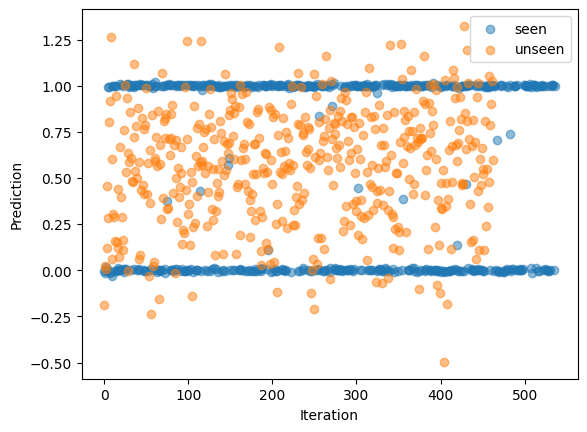

In [12]:
plt.scatter(np.arange(len(seen_logits)), seen_logits, alpha=0.5, label='seen')
plt.scatter(np.arange(len(unseen_logits)), unseen_logits, alpha=0.5, label='unseen')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.show()

In [13]:
# Check accuracy limit over time of just using logit as input to meta-model
# Is there anything to be gained by added more info than this?
# Look up intrinsic stuff briefly


In [14]:
# Train meta-model with same parameters

meta_input_dim = 1
meta_loss_threshold = 0.1

# Initialize model and optimizer (should it/they be reoptimized every time?)
meta_model = FFNN(meta_input_dim, hidden_dim, n_layers, activation)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
meta_x_train = torch.tensor(logits_pred, dtype=torch.float32).unsqueeze(1)
meta_y_train = torch.tensor(labels_true, dtype=torch.float32).unsqueeze(1) 

# Initialize record-keeping
meta_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Collect prediction
    meta_model.eval()
    with torch.no_grad():
        logits = meta_model(meta_x_train[iteration])
        meta_pred.append(logits[0].item())
        
    # Get current data set
    x_train = meta_x_train[:iteration + 1]
    y_train = meta_y_train[:iteration + 1]

    # Update meta-model
    train_to_convergence(meta_model, x_train, y_train, meta_optimizer, criterion, loss_threshold=meta_loss_threshold)    

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 287.70it/s]


In [15]:
# Separate seen and unseen for plotting
seen_meta_pred = []
unseen_meta_pred = []
for label, pred in zip(labels_true, meta_pred):
    if label:
        seen_meta_pred.append(pred)
    else:
        unseen_meta_pred.append(pred)

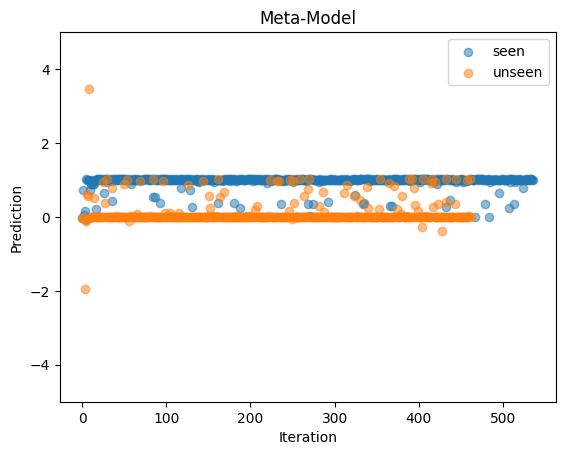

In [16]:
plt.scatter(np.arange(len(seen_meta_pred)), seen_meta_pred, alpha=0.5, label='seen')
plt.scatter(np.arange(len(unseen_meta_pred)), unseen_meta_pred, alpha=0.5, label='unseen')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.title("Meta-Model")
plt.ylim(-5, 5)
plt.show()

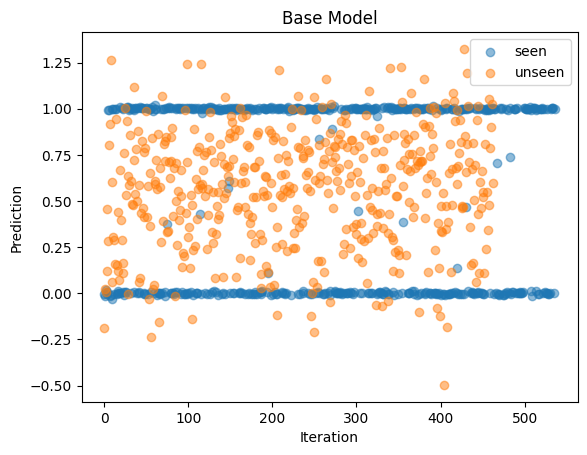

In [17]:
plt.scatter(np.arange(len(seen_logits)), seen_logits, alpha=0.5, label='seen')
plt.scatter(np.arange(len(unseen_logits)), unseen_logits, alpha=0.5, label='unseen')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.title("Base Model")
plt.show()

In [18]:
# Compute accuracy of base model and meta-model
def accuracy(true, preds, threshold=0.5):
    return (true == (np.array(preds) > threshold)).mean()

In [19]:
accuracy(labels_true, meta_pred)

np.float64(0.916)

In [20]:
accuracy(labels_true, probs_pred)

np.float64(0.471)

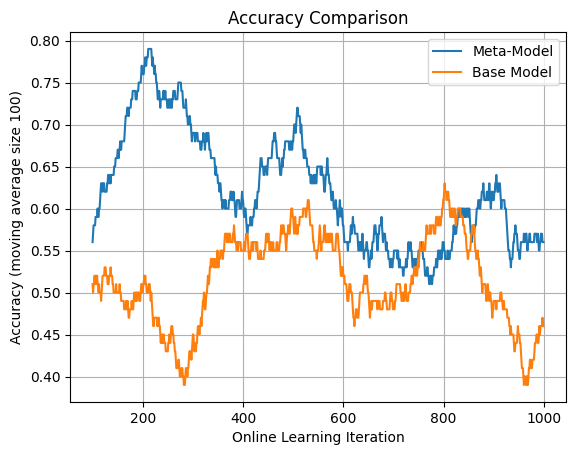

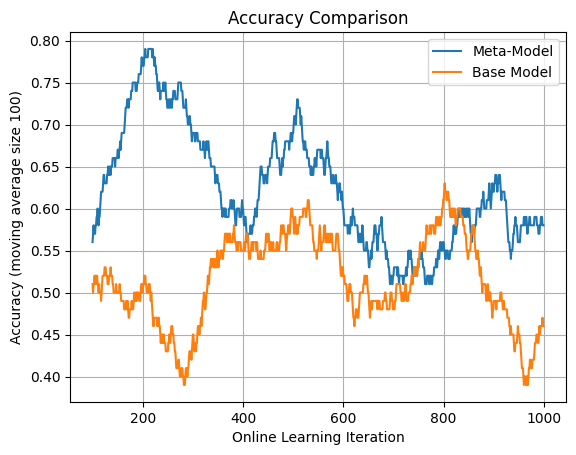

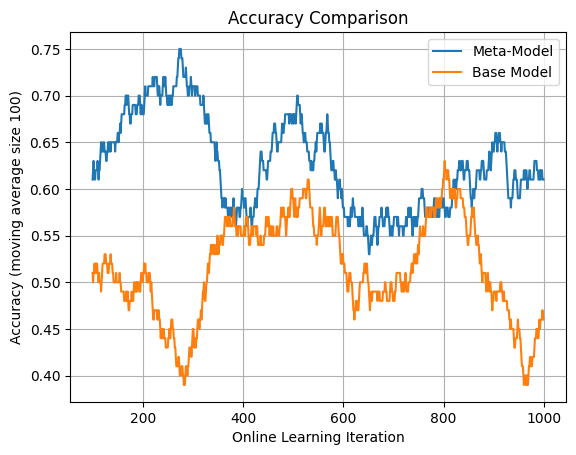

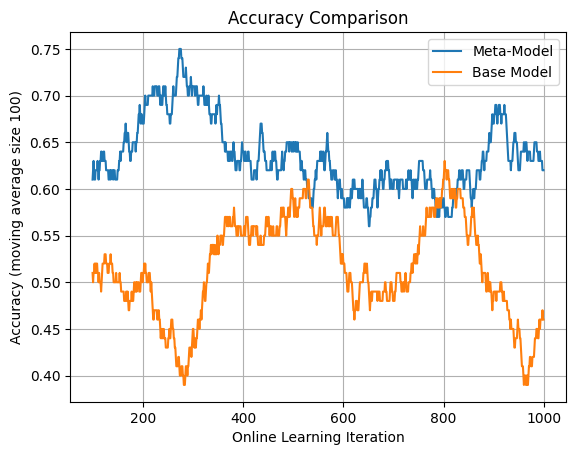

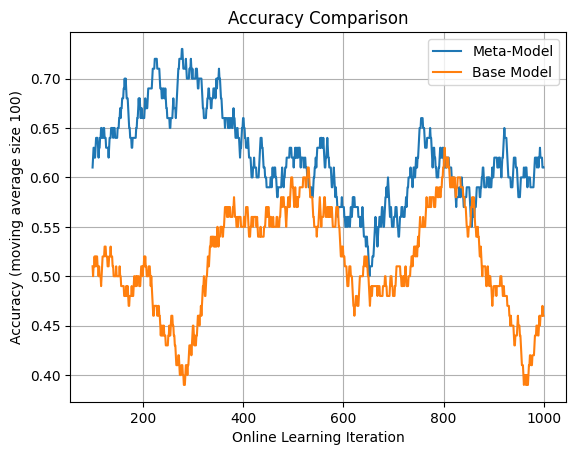

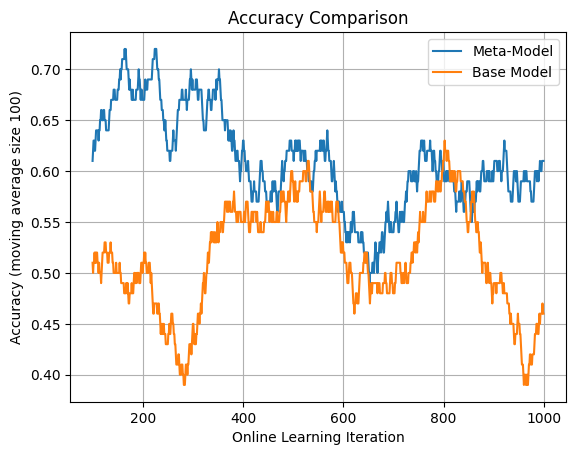

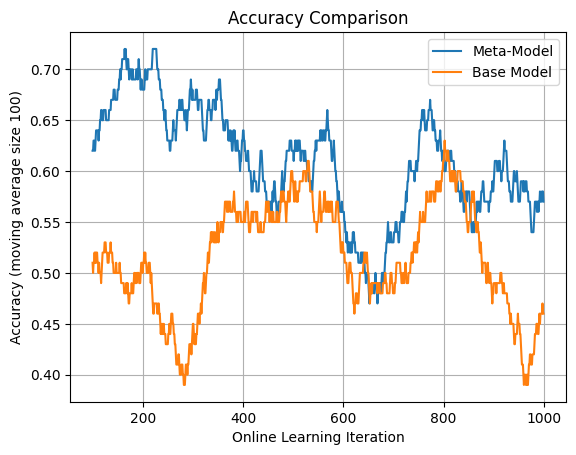

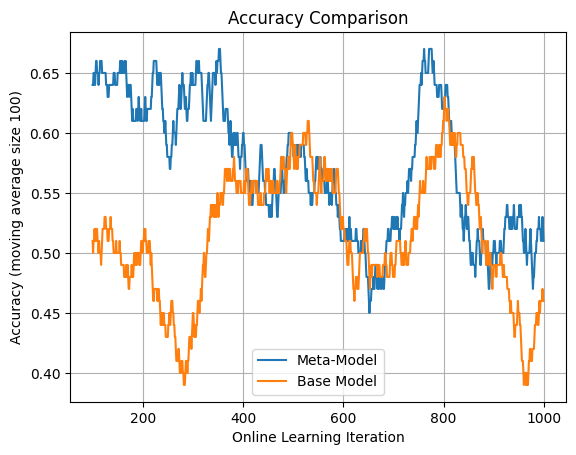

In [239]:
# Plot accuracies over time
for threshold in -5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5:
    window_size = 100
    base_accs = []
    meta_accs = []
    for i in range(window_size, len(labels_true)):
        base_accs.append(accuracy(labels_true[i-window_size:i], probs_pred[i-window_size:i]))
        meta_accs.append(accuracy(labels_true[i-window_size:i], meta_pred[i-window_size:i], threshold))
    
    plt.plot(np.arange(window_size, len(labels_true)), meta_accs, label='Meta-Model')
    plt.plot(np.arange(window_size, len(labels_true)), base_accs, label='Base Model')
    plt.legend()
    plt.ylabel("Accuracy (moving average size 100)")
    plt.xlabel("Online Learning Iteration")
    plt.title("Accuracy Comparison")
    plt.grid()
    plt.show()

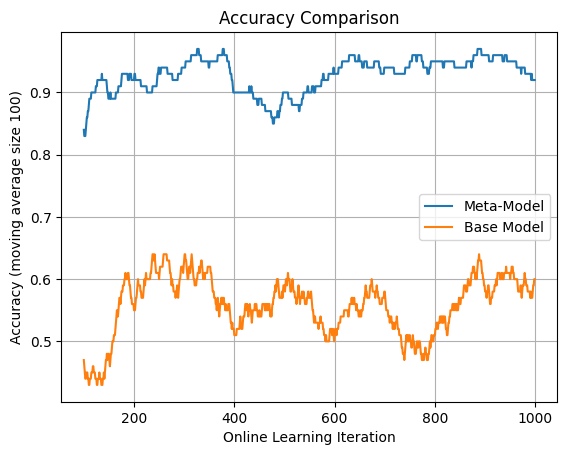

In [224]:
plt.plot(np.arange(window_size, len(labels_true)), meta_accs, label='Meta-Model')
plt.plot(np.arange(window_size, len(labels_true)), base_accs, label='Base Model')
plt.legend()
plt.ylabel("Accuracy (moving average size 100)")
plt.xlabel("Online Learning Iteration")
plt.title("Accuracy Comparison")
plt.grid()
plt.show()

In [8]:
#
# Training Loop
#

# Hyperparameters
n_iterations = 1000
unseen_rate = 0.5
input_dim = 20
hidden_dim = 256
n_layers = 2
loss_threshold = 0.01  # stop training when loss falls below this
max_epochs = 1000
learning_rate = 1e-3
weight_decay = 0
activation = 'relu'
criterion_name = 'log_loss'
if criterion_name == 'mse':
    criterion = nn.MSELoss()
elif criterion_name == 'mae':
    criterion = nn.L1Loss()
elif criterion_name == 'log_loss':
    criterion = nn.BCEWithLogitsLoss()

# Initialize model and optimizer (should it/they be reoptimized every time?)
model = FFNN(input_dim, hidden_dim, n_layers, activation)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
data_dict = {}

# Initialize record-keeping
labels_true = []
logits_pred = []
probs_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Encounter new sample
    x, y = generate_sample(data_dict)
    labels_true.append(y[0].item())

    # Collect prediction
    model.eval()
    with torch.no_grad():
        logits = model(x)
        logits_pred.append(logits[0].item())
        if criterion_name == 'log_loss':
            probs = torch.sigmoid(logits)  # now in [0, 1]
            probs_pred.append(probs[0].item())
        else:
            probs_pred.append(logits_pred[-1])

    # Update model
    x_train, y_train = dict_to_dataset(data_dict)
    train_to_convergence(model, x_train, y_train, optimizer, criterion, loss_threshold=loss_threshold)
    

  0%|▎                                                                          | 4/1000 [00:00<01:24, 11.80it/s]


KeyboardInterrupt: 

In [229]:
# Train meta-model with same parameters

meta_input_dim = 1
meta_loss_threshold = 0.1

# Initialize model and optimizer (should it/they be reoptimized every time?)
meta_model = FFNN(meta_input_dim, hidden_dim, n_layers, activation)
meta_optimizer = optim.Adam(meta_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize dataset
meta_x_train = torch.tensor(logits_pred, dtype=torch.float32).unsqueeze(1)
meta_y_train = torch.tensor(labels_true, dtype=torch.float32).unsqueeze(1) 

# Initialize record-keeping
meta_pred = []

# Run online learning iterations
for iteration in tqdm(range(n_iterations)):
    
    # Collect prediction
    meta_model.eval()
    with torch.no_grad():
        logits = meta_model(meta_x_train[iteration])
        meta_pred.append(logits[0].item())
        
    # Get current data set
    x_train = meta_x_train[:iteration + 1]
    y_train = meta_y_train[:iteration + 1]

    # Update meta-model
    train_to_convergence(meta_model, x_train, y_train, meta_optimizer, criterion, loss_threshold=meta_loss_threshold, max_epochs=100)    

100%|██████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.95it/s]
